# Assignment #9 [ERA v2]

### Abstract
In this assignment we are going to train the CIFAR10 dataset to achieve 85% validation accuracy using less than 20,000 parameters, In this assignment there is no restriction on the number of epoch.


CIFAR10 dataset has image size of 32x32x3 and has 10 classes

### Step 1: Import the required modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

### Step 2: Preparing the Training and Testing Data

#### 2.0: View the Test and Training DataSet

100%|██████████| 170498071/170498071 [00:04<00:00, 42435360.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


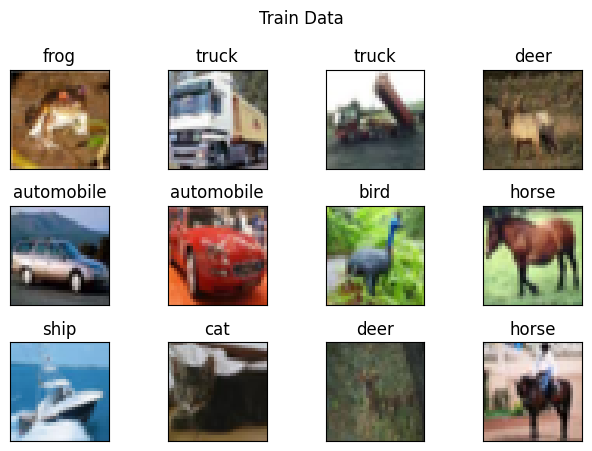

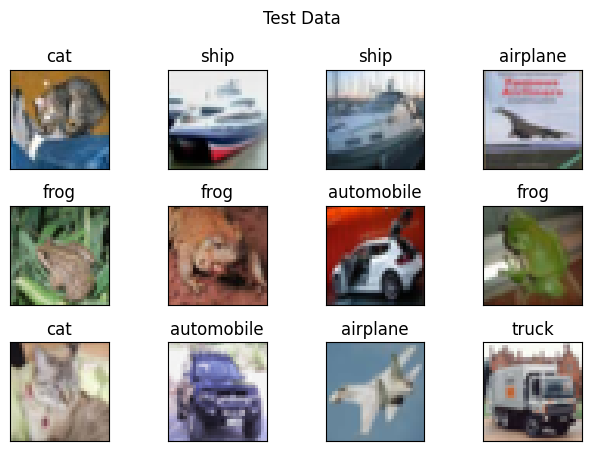

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# View the Training and Test Data
train_CIFAR = datasets.CIFAR10('./data', train=True, download=True)
test_CIFAR = datasets.CIFAR10('./data', train=False, download=True)

def showSampleImages(dataSet, title):
    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        img, label = dataSet[i]
        plt.imshow(img, cmap='gray')
        plt.title(dataSet.classes[label])
        plt.xticks([])
        plt.yticks([])

print('CIFAR classes :',train_CIFAR.classes)
showSampleImages(train_CIFAR, "Train Data")
showSampleImages(test_CIFAR, "Test Data")

#### 2.1 Analyse the Dataset and find the Mean and Standard Deviation

Files already downloaded and verified
------ CIFAR10 Dataset Type and Classes ------
exp_CIFAR type =>  <class 'numpy.ndarray'>
------ CIFAR10 Sample Image - InTensor  ------
Files already downloaded and verified


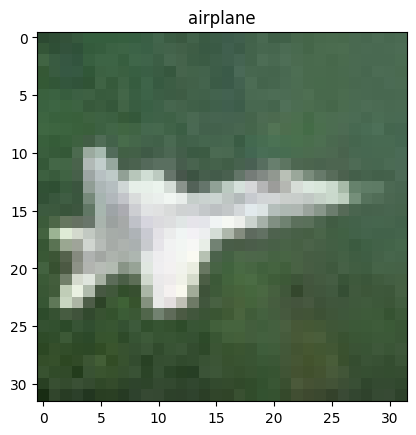

------ CIFAR10 Dataset MEAN & STD_DEV ------
Shape of CIFAR10 => torch.Size([3, 32, 32]) torch.float32
Mean of CIFAR10 =>  tensor([0.4914, 0.4822, 0.4465])
Std Dev of CIFAR10 =>  tensor([0.2470, 0.2435, 0.2616])
------ CIFAR10 Sample Image - Normalized ------


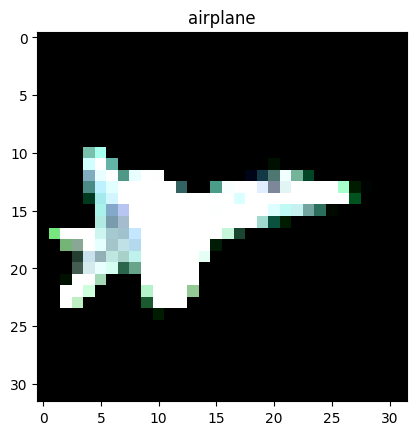

In [3]:
# Index of the sample image
idx = 77

# Download the dataset
exp_CIFAR = datasets.CIFAR10('./data', train=True, download=True)

print('------ CIFAR10 Dataset Type and Classes ------')
print('exp_CIFAR type => ',type(exp_CIFAR.data))

print('------ CIFAR10 Sample Image - InTensor  ------')
tns_CIFAR = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
img_t,label = tns_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

print('------ CIFAR10 Dataset MEAN & STD_DEV ------')
imgs = torch.stack([img_t for img_t ,_ in tns_CIFAR],dim=3)
imgs.shape
print('Shape of CIFAR10 =>', img_t.shape, img_t.dtype)
print('Mean of CIFAR10 => ',imgs.view(3,-1).mean(dim=1))
print('Std Dev of CIFAR10 => ',imgs.view(3, -1).std(dim=1))

print('------ CIFAR10 Sample Image - Normalized ------')
trs_CIFAR = datasets.CIFAR10('./data', train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]))
img_t,label = trs_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

#### 2.2 Defining Train and Test Phase Transformartions

In [32]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# cutout needs to be half of the image size
cutout_size = 16

# Train Phase Transformations
train_transforms = A.Compose(
    A.Compose([
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=12, p=0.5),
        A.CoarseDropout( max_holes=1, max_height=cutout_size, max_width=cutout_size,
                        min_holes=1, min_height=cutout_size, min_width=cutout_size,
                        fill_value=[0.4915, 0.4823, 0.4468], mask_fill_value=None),
        A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
        ToTensorV2(),
    ])
)

# Test Phase Transformations
test_transforms = A.Compose(A.Compose([
    A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
    ToTensorV2(),
]))


#### 2.3 Download the Dataset and Splitting Train and Test Data

In [36]:
import cv2
import os
import copy
from torch.utils.data import Dataset
from torchvision import datasets

class CIFAR10_Transforms(Dataset):
    def __init__(self, dataset, transforms):
        self.transforms = transforms
        self.dataset = dataset

    def __getitem__(self, idx):
        # Get the image and label from the dataset
        image, label = self.dataset[idx]

        # Apply transformations on the image
        image = self.transforms(image=np.array(image))["image"]

        return image, label

    def __len__(self):
        return len(self.dataset)

    def __repr__(self):
        return (f"CIFAR10_Transforms(dataset={self.dataset}, transforms={self.transforms})")

    def __str__(self):
        return (f"CIFAR10_Transforms(dataset={self.dataset}, transforms={self.transforms})")

train_data = datasets.CIFAR10('../data', train=True, download=True)
test_data = datasets.CIFAR10('../data', train=False, download=True)

train_data = CIFAR10_Transforms(train_data, train_transforms)
test_data = CIFAR10_Transforms(test_data, test_transforms)


Files already downloaded and verified
Files already downloaded and verified


#### 2.4 Dataloader Arguments & Test/Train Dataloaders

In [37]:
# Set the seed for Reproducible results
SEED = 1
set_manualSeed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda_availabilty() else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


### Step 3: Initilizing the model

In [79]:
from torchsummary import summary
device = selectDevice()
model = Network().to(device)
summary(model, input_size=(3, 32, 32))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 30, 30]           9,216
      BatchNorm2d-10           [-1, 32, 30, 30]              64
             ReLU-11           [-1, 32, 30, 30]               0
          Dropout-12           [-1, 32, 30, 30]               0
           Conv2d-13           [-1, 32, 30, 30]           9,216
      BatchNorm2d-14       

### Step 4: Training and Testing the model

In [80]:
from torch.optim.lr_scheduler import StepLR

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

criterion = F.nll_loss
num_epoch = 60

for epoch in range(num_epoch):
    print('Epoch : ',epoch)
    train_acc, train_losses = train(model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    test_acc, test_losses = test(model, device, test_loader, criterion, test_acc, test_losses)
    scheduler.step()

Epoch :  0


Train: Loss=1.6922 Batch_id=390 Accuracy=30.62: 100%|██████████| 391/391 [00:18<00:00, 21.39it/s]


Test set: Average loss: 1.5508, Accuracy: 4129/10000 (41.29%)

Epoch :  1


Train: Loss=1.4661 Batch_id=390 Accuracy=44.72: 100%|██████████| 391/391 [00:17<00:00, 22.62it/s]


Test set: Average loss: 1.3973, Accuracy: 4790/10000 (47.90%)

Epoch :  2


Train: Loss=1.3771 Batch_id=390 Accuracy=50.67: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]


Test set: Average loss: 1.2864, Accuracy: 5403/10000 (54.03%)

Epoch :  3


Train: Loss=1.0862 Batch_id=390 Accuracy=54.74: 100%|██████████| 391/391 [00:17<00:00, 22.84it/s]


Test set: Average loss: 1.0988, Accuracy: 6024/10000 (60.24%)

Epoch :  4


Train: Loss=1.0785 Batch_id=390 Accuracy=57.79: 100%|██████████| 391/391 [00:18<00:00, 21.11it/s]


Test set: Average loss: 0.9754, Accuracy: 6510/10000 (65.10%)

Epoch :  5


Train: Loss=1.3366 Batch_id=390 Accuracy=60.16: 100%|██████████| 391/391 [00:17<00:00, 22.28it/s]


Test set: Average loss: 0.9050, Accuracy: 6746/10000 (67.46%)

Epoch :  6


Train: Loss=1.1541 Batch_id=390 Accuracy=61.83: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]


Test set: Average loss: 0.8786, Accuracy: 6859/10000 (68.59%)

Epoch :  7


Train: Loss=0.9252 Batch_id=390 Accuracy=63.58: 100%|██████████| 391/391 [00:17<00:00, 22.61it/s]


Test set: Average loss: 0.8570, Accuracy: 6988/10000 (69.88%)

Epoch :  8


Train: Loss=0.9901 Batch_id=390 Accuracy=64.90: 100%|██████████| 391/391 [00:17<00:00, 22.80it/s]


Test set: Average loss: 0.7729, Accuracy: 7259/10000 (72.59%)

Epoch :  9


Train: Loss=0.7887 Batch_id=390 Accuracy=66.27: 100%|██████████| 391/391 [00:17<00:00, 22.86it/s]


Test set: Average loss: 0.7729, Accuracy: 7314/10000 (73.14%)

Epoch :  10


Train: Loss=0.9441 Batch_id=390 Accuracy=67.14: 100%|██████████| 391/391 [00:17<00:00, 22.91it/s]


Test set: Average loss: 0.7099, Accuracy: 7495/10000 (74.95%)

Epoch :  11


Train: Loss=0.7521 Batch_id=390 Accuracy=68.20: 100%|██████████| 391/391 [00:17<00:00, 22.97it/s]


Test set: Average loss: 0.8037, Accuracy: 7231/10000 (72.31%)

Epoch :  12


Train: Loss=0.9351 Batch_id=390 Accuracy=68.79: 100%|██████████| 391/391 [00:16<00:00, 23.12it/s]


Test set: Average loss: 0.6654, Accuracy: 7723/10000 (77.23%)

Epoch :  13


Train: Loss=0.6792 Batch_id=390 Accuracy=69.64: 100%|██████████| 391/391 [00:16<00:00, 23.17it/s]


Test set: Average loss: 0.6884, Accuracy: 7613/10000 (76.13%)

Epoch :  14


Train: Loss=0.8566 Batch_id=390 Accuracy=70.12: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]


Test set: Average loss: 0.6578, Accuracy: 7744/10000 (77.44%)

Epoch :  15


Train: Loss=0.7930 Batch_id=390 Accuracy=72.63: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]


Test set: Average loss: 0.5780, Accuracy: 7992/10000 (79.92%)

Epoch :  16


Train: Loss=0.6541 Batch_id=390 Accuracy=73.05: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s]


Test set: Average loss: 0.5788, Accuracy: 7989/10000 (79.89%)

Epoch :  17


Train: Loss=0.6282 Batch_id=390 Accuracy=73.34: 100%|██████████| 391/391 [00:17<00:00, 22.49it/s]


Test set: Average loss: 0.5753, Accuracy: 8009/10000 (80.09%)

Epoch :  18


Train: Loss=0.9369 Batch_id=390 Accuracy=73.52: 100%|██████████| 391/391 [00:17<00:00, 22.72it/s]


Test set: Average loss: 0.5624, Accuracy: 8072/10000 (80.72%)

Epoch :  19


Train: Loss=0.7423 Batch_id=390 Accuracy=73.58: 100%|██████████| 391/391 [00:17<00:00, 21.90it/s]


Test set: Average loss: 0.5752, Accuracy: 8012/10000 (80.12%)

Epoch :  20


Train: Loss=0.7084 Batch_id=390 Accuracy=73.51: 100%|██████████| 391/391 [00:17<00:00, 22.48it/s]


Test set: Average loss: 0.5593, Accuracy: 8076/10000 (80.76%)

Epoch :  21


Train: Loss=0.7401 Batch_id=390 Accuracy=73.68: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s]


Test set: Average loss: 0.5665, Accuracy: 8028/10000 (80.28%)

Epoch :  22


Train: Loss=0.8202 Batch_id=390 Accuracy=74.22: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]


Test set: Average loss: 0.5626, Accuracy: 8062/10000 (80.62%)

Epoch :  23


Train: Loss=0.5670 Batch_id=390 Accuracy=73.92: 100%|██████████| 391/391 [00:20<00:00, 19.11it/s]


Test set: Average loss: 0.5443, Accuracy: 8120/10000 (81.20%)

Epoch :  24


Train: Loss=0.9844 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:17<00:00, 22.85it/s]


Test set: Average loss: 0.5624, Accuracy: 8074/10000 (80.74%)

Epoch :  25


Train: Loss=0.8097 Batch_id=390 Accuracy=74.03: 100%|██████████| 391/391 [00:17<00:00, 22.16it/s]


Test set: Average loss: 0.5485, Accuracy: 8118/10000 (81.18%)

Epoch :  26


Train: Loss=0.5756 Batch_id=390 Accuracy=74.32: 100%|██████████| 391/391 [00:17<00:00, 22.84it/s]


Test set: Average loss: 0.5539, Accuracy: 8122/10000 (81.22%)

Epoch :  27


Train: Loss=0.9191 Batch_id=390 Accuracy=74.47: 100%|██████████| 391/391 [00:17<00:00, 21.97it/s]


Test set: Average loss: 0.5436, Accuracy: 8153/10000 (81.53%)

Epoch :  28


Train: Loss=0.7293 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]


Test set: Average loss: 0.5452, Accuracy: 8120/10000 (81.20%)

Epoch :  29


Train: Loss=0.8481 Batch_id=390 Accuracy=74.56: 100%|██████████| 391/391 [00:17<00:00, 22.62it/s]


Test set: Average loss: 0.5378, Accuracy: 8197/10000 (81.97%)

Epoch :  30


Train: Loss=0.6486 Batch_id=390 Accuracy=74.65: 100%|██████████| 391/391 [00:17<00:00, 22.25it/s]


Test set: Average loss: 0.5362, Accuracy: 8173/10000 (81.73%)

Epoch :  31


Train: Loss=0.7452 Batch_id=390 Accuracy=74.89: 100%|██████████| 391/391 [00:17<00:00, 22.53it/s]


Test set: Average loss: 0.5364, Accuracy: 8169/10000 (81.69%)

Epoch :  32


Train: Loss=0.7812 Batch_id=390 Accuracy=74.97: 100%|██████████| 391/391 [00:17<00:00, 22.71it/s]


Test set: Average loss: 0.5360, Accuracy: 8172/10000 (81.72%)

Epoch :  33


Train: Loss=0.8501 Batch_id=390 Accuracy=74.76: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s]


Test set: Average loss: 0.5381, Accuracy: 8165/10000 (81.65%)

Epoch :  34


Train: Loss=0.8548 Batch_id=390 Accuracy=74.94: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]


Test set: Average loss: 0.5355, Accuracy: 8174/10000 (81.74%)

Epoch :  35


Train: Loss=0.9400 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 0.5371, Accuracy: 8159/10000 (81.59%)

Epoch :  36


Train: Loss=0.6943 Batch_id=390 Accuracy=74.91: 100%|██████████| 391/391 [00:18<00:00, 21.52it/s]


Test set: Average loss: 0.5368, Accuracy: 8150/10000 (81.50%)

Epoch :  37


Train: Loss=0.6078 Batch_id=390 Accuracy=74.92: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


Test set: Average loss: 0.5346, Accuracy: 8164/10000 (81.64%)

Epoch :  38


Train: Loss=1.0410 Batch_id=390 Accuracy=74.94: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]


Test set: Average loss: 0.5332, Accuracy: 8182/10000 (81.82%)

Epoch :  39


Train: Loss=0.7806 Batch_id=390 Accuracy=75.30: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s]


Test set: Average loss: 0.5336, Accuracy: 8185/10000 (81.85%)

Epoch :  40


Train: Loss=0.5951 Batch_id=390 Accuracy=74.96: 100%|██████████| 391/391 [00:17<00:00, 21.74it/s]


Test set: Average loss: 0.5412, Accuracy: 8145/10000 (81.45%)

Epoch :  41


Train: Loss=0.7608 Batch_id=390 Accuracy=75.10: 100%|██████████| 391/391 [00:17<00:00, 22.74it/s]


Test set: Average loss: 0.5342, Accuracy: 8169/10000 (81.69%)

Epoch :  42


Train: Loss=0.6936 Batch_id=390 Accuracy=75.14: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Test set: Average loss: 0.5294, Accuracy: 8181/10000 (81.81%)

Epoch :  43


Train: Loss=0.7083 Batch_id=390 Accuracy=75.04: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]


Test set: Average loss: 0.5333, Accuracy: 8181/10000 (81.81%)

Epoch :  44


Train: Loss=0.8976 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]


Test set: Average loss: 0.5334, Accuracy: 8178/10000 (81.78%)

Epoch :  45


Train: Loss=0.5229 Batch_id=390 Accuracy=75.05: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Test set: Average loss: 0.5309, Accuracy: 8186/10000 (81.86%)

Epoch :  46


Train: Loss=0.5490 Batch_id=390 Accuracy=75.12: 100%|██████████| 391/391 [00:17<00:00, 21.86it/s]


Test set: Average loss: 0.5340, Accuracy: 8178/10000 (81.78%)

Epoch :  47


Train: Loss=0.8238 Batch_id=390 Accuracy=75.28: 100%|██████████| 391/391 [00:18<00:00, 21.47it/s]


Test set: Average loss: 0.5312, Accuracy: 8187/10000 (81.87%)

Epoch :  48


Train: Loss=0.5964 Batch_id=390 Accuracy=75.06: 100%|██████████| 391/391 [00:17<00:00, 21.99it/s]


Test set: Average loss: 0.5353, Accuracy: 8171/10000 (81.71%)

Epoch :  49


Train: Loss=0.7514 Batch_id=390 Accuracy=75.20: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]


Test set: Average loss: 0.5348, Accuracy: 8174/10000 (81.74%)

Epoch :  50


Train: Loss=0.7380 Batch_id=390 Accuracy=75.30: 100%|██████████| 391/391 [00:17<00:00, 22.46it/s]


Test set: Average loss: 0.5349, Accuracy: 8166/10000 (81.66%)

Epoch :  51


Train: Loss=0.8207 Batch_id=390 Accuracy=75.32: 100%|██████████| 391/391 [00:18<00:00, 21.28it/s]


Test set: Average loss: 0.5306, Accuracy: 8189/10000 (81.89%)

Epoch :  52


Train: Loss=0.7055 Batch_id=390 Accuracy=75.25: 100%|██████████| 391/391 [00:17<00:00, 22.42it/s]


Test set: Average loss: 0.5354, Accuracy: 8175/10000 (81.75%)

Epoch :  53


Train: Loss=0.7238 Batch_id=390 Accuracy=75.10: 100%|██████████| 391/391 [00:18<00:00, 21.24it/s]


Test set: Average loss: 0.5325, Accuracy: 8178/10000 (81.78%)

Epoch :  54


Train: Loss=0.8557 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:17<00:00, 22.90it/s]


Test set: Average loss: 0.5355, Accuracy: 8168/10000 (81.68%)

Epoch :  55


Train: Loss=0.7816 Batch_id=390 Accuracy=75.05: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s]


Test set: Average loss: 0.5335, Accuracy: 8200/10000 (82.00%)

Epoch :  56


Train: Loss=0.8210 Batch_id=390 Accuracy=75.12: 100%|██████████| 391/391 [00:17<00:00, 22.99it/s]


Test set: Average loss: 0.5299, Accuracy: 8183/10000 (81.83%)

Epoch :  57


Train: Loss=0.7318 Batch_id=390 Accuracy=74.98: 100%|██████████| 391/391 [00:17<00:00, 22.09it/s]


Test set: Average loss: 0.5326, Accuracy: 8196/10000 (81.96%)

Epoch :  58


Train: Loss=1.2233 Batch_id=390 Accuracy=75.16: 100%|██████████| 391/391 [00:17<00:00, 22.78it/s]


Test set: Average loss: 0.5289, Accuracy: 8187/10000 (81.87%)

Epoch :  59


Train: Loss=0.7081 Batch_id=390 Accuracy=75.04: 100%|██████████| 391/391 [00:18<00:00, 21.69it/s]


Test set: Average loss: 0.5324, Accuracy: 8171/10000 (81.71%)



### Step 5: Analyze Training, Testing Loss and Accuracy

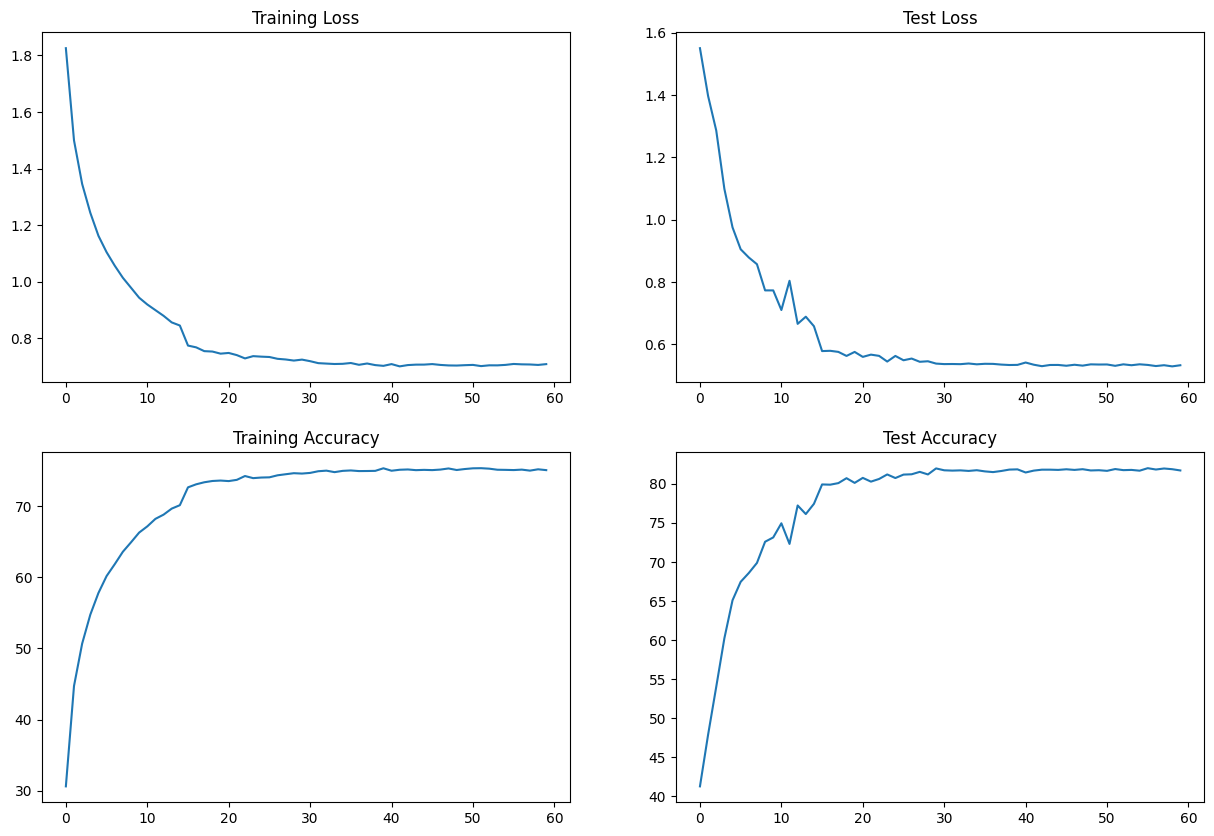

In [81]:
viewAnalysis(train_losses, train_acc, test_losses, test_acc)

# Model

<!--
    TODO:
        • Model to have 200K params
        • Acheive 85% accuracy
        • No limit on Epoch
        • Total RF to be greater than 44
-->

In [78]:
dropout_value = 0.1

'''
    Model Architecture => C1 [] => C2 [] => C3 [] => C4 [] =>
    Input Size == Output Size -> for a Block
'''
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Convolution Block 1   [C1 + C2 + C3]
        self.convBlock1 = nn.Sequential(
            # Convolution 1                     32x32x3 -> 32x32x8 -> RF 3
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 2                     32x32x8 -> 32x32x32 -> RF 5
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 3                     32x32x32 -> 30x30x32 -> RF 9  ( 5+(5-1)*1 = 9 )   => Dilation of 2 makes K=5
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )


        # Convolution Block 2   [C4 + C5 + C6]
        self.convBlock2 = nn.Sequential(
            # Convolution 4                     30x30x8 -> 30x30x8 -> RF 11
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 5                     30x30x8 -> 30x30x8 -> RF 13
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 6                     30x30x8 -> 15x15x8 -> RF 15 ( 13+(3-1)*1 = 15 ) Jout = 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )


        # Convolution Block 3   [C7 + C8 + C9]
        self.convBlock3 = nn.Sequential(
            # Convolution 7                     15x15x8 -> 15x15x8 -> RF 19 ( 15+(3-1)*2 = 19 )
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 8                     15x15x8 -> 15x15x8 -> RF 23
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 9                     15x15x8 -> 7x7x8 -> RF 27 ( 23+(3-1)*2 = 27 ) Jout = 4
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )


        # Convolution Block 4   [C10 + C11 + C12]
        self.convBlock4 = nn.Sequential(
            # # Convolution 10                     7x7x8 -> 7x7x8 -> RF 35 ( 27+(3-1)*4 = 35 )
            # nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            # nn.BatchNorm2d(8),
            # nn.ReLU(),
            # nn.Dropout(dropout_value),

            # Convolution 10                     7x7x8 -> 7x7x8 -> RF 35 ( 27+(3-1)*4 = 35 )    => Depthwise Separable Convolution
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, groups=16, bias=False),  # Depthwise Convolution
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),            # Pointwise Convolution
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            # Convolution 11                     7x7x8 -> 7x7x8 -> RF 43
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 12                     7x7x8 -> 7x7x8 -> RF 51
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )


        # GAP Layer [GAP]
        self.gap = nn.Sequential(
            # Global Average Pooling            7x7x64 -> 1x1x64 -> RF 51
            nn.AvgPool2d(kernel_size=7)
        )


        # Output Block [c13]
        self.outputBlock = nn.Sequential(
            # Convolution 13                    1x1x64 -> 1x1x10 -> RF 51
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        x = self.convBlock4(x)
        x = self.gap(x)
        x = self.outputBlock(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Utility functions

### utils.py

In [7]:
""" Function to mount Google Drive to your workspace """
def mountDrive():
    from google.colab import drive
    drive.mount('/content/drive')

""" Checking if we have CUDA enabled GPU or not, """
def cuda_availabilty():
    return torch.cuda.is_available()

""" Function to set manual seed for reproducible results """
def set_manualSeed(seed):
    # Sets the seed for PyTorch's Random Number Generator
    torch.manual_seed(seed)
    if cuda_availabilty():
        torch.cuda.manual_seed(seed)

""" Function to select Device """
def selectDevice():
    using_cuda = cuda_availabilty()
    print("Using CUDA!" if using_cuda else "Not using CUDA.")
    # if so select "cuda" as device for processing else "cpu"
    device = torch.device("cuda" if using_cuda else "cpu")
    return device

""" Function to download the MNIST dataset """
def download_MNIST(train, transform):
    from torchvision import datasets
    return datasets.MNIST('../data', train=train, download=True, transform=transform)

""" Function to download the CIFAR10 dataset """
def download_CIFAR10(train, transform):
    from torchvision import datasets
    return datasets.CIFAR10('../data', train=train, download=True, transform=transform)

""" Function to view the statistics around our data """
def stats_dataset(data):
    train_data = data.train_data
    train_data = data.transform(train_data.numpy())

    print('[Train]')
    print(' - Numpy Shape:', data.train_data.cpu().numpy().shape)
    print(' - Tensor Shape:', data.train_data.size())
    print(' - min:', torch.min(train_data))     # Min Pixel Value
    print(' - max:', torch.max(train_data))     # Max Pixel Value
    print(' - mean:', torch.mean(train_data))
    print(' - std:', torch.std(train_data))
    print(' - var:', torch.var(train_data))

"""Funciton to view the samples in dataset """
def view_dataset(data_loader, title):
    import matplotlib.pyplot as plt

    batch_data, batch_label = next(iter(data_loader))

    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
      plt.subplot(3,4,i+1)
      plt.tight_layout()
      plt.imshow(batch_data[i].squeeze(0).permute(1,2,0), cmap='gray')
      plt.title(batch_label[i].item())
      plt.xticks([])
      plt.yticks([])

""" Function to Get Correct Prediction Count """
def GetCorrectPredCount(pPrediction, pLabels ):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

""" Function to view the Training and Testing Accuracy and Loss """
def viewAnalysis(train_losses, train_acc, test_losses, test_acc):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

""" Function to plot the misClassified Images """
def plotMisClassifiedImages(model, device, test_loader,classes):
    classes = test_data.classes
    model.eval()
    misClassifiedImages = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            idxs_mask = ~pred.eq(target.view_as(pred)).view(-1)
            misClassifiedImages.extend([(data[i], pred[i], target[i]) for i in range(len(idxs_mask)) if idxs_mask[i]])
            if len(misClassifiedImages) >= 10:
                break

    misClassifiedImages = misClassifiedImages[:10]

    fig, axes = plt.subplots(5, 2, figsize=(8, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, (img, pred, target) in enumerate(misClassifiedImages):
        img, pred, target = img.cpu().numpy(), pred.cpu(), target.cpu()
        ax = axes[i//2, i%2]
        img = img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean  # De-normalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Predicted: {classes[pred.item()]}, Actual: {classes[target.item()]}')
        ax.axis('off')

    plt.show()

In [8]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Get a batch of samples
        data, target = data.to(device) , target.to(device)
        # Initilizes the gradients to zero
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate Loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    return train_acc, train_losses

def test(model, device, test_loader, criterion, test_acc, test_losses):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target, reduction='sum').item()  # Sum up batch loss
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_acc, test_losses